# 25k: Information Value

**Goal**: Quantify the value of knowing opponent hands

**Key Question**: How much is perfect information worth?

**Method**:
Using marginalized data (same P0 hand, 3 opponent configs):
1. For each state, find Q-values in each opponent config
2. Perfect info strategy: pick best action for THIS config
3. Robust strategy: pick best action averaged across configs
4. Information value = Q[perfect] - Q[robust]

**Expected Output**: "Knowing opponent hands worth X pts at depth Y"

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"
MARG_DIR = PROJECT_ROOT + "/data/shards-marginalized/train"
N_SEEDS = 2  # Very small for memory constraints
MAX_COMMON_STATES = 2000  # Reduced from 5000

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
import gc

from forge.analysis.utils import viz
from forge.oracle import schema
from forge.oracle.rng import deal_from_seed

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


In [2]:
def compute_depth(state: int) -> int:
    """Compute total dominoes remaining."""
    depth = 0
    for p in range(4):
        remaining = (state >> (p * 7)) & 0x7F
        depth += bin(remaining).count('1')
    return depth

def find_marginalized_seeds(marg_dir: Path, limit: int = 100) -> list:
    """Find base seeds that have all 3 opponent configs."""
    marg_dir = Path(marg_dir)
    files = list(marg_dir.glob("*.parquet"))
    
    # Extract base seeds
    seeds_by_base = {}
    for f in files:
        parts = f.stem.split('_')
        base_seed = int(parts[1])
        opp_seed = parts[2]  # 'opp0', 'opp1', 'opp2'
        
        if base_seed not in seeds_by_base:
            seeds_by_base[base_seed] = set()
        seeds_by_base[base_seed].add(opp_seed)
    
    # Find seeds with all 3 configs
    complete_seeds = [s for s, opps in seeds_by_base.items() 
                     if len(opps) >= 3]
    
    return sorted(complete_seeds)[:limit]

# Find complete seeds
complete_seeds = find_marginalized_seeds(MARG_DIR, limit=N_SEEDS)
print(f"Found {len(complete_seeds)} seeds with all 3 opponent configs")

Found 2 seeds with all 3 opponent configs


## 1. Load Marginalized Data

In [3]:
import pyarrow.parquet as pq

def load_seed_configs_memory_efficient(base_seed: int, marg_dir: Path, max_rows: int = 50000) -> dict:
    """Load all 3 configs for a base seed - only state and Q columns, limited rows."""
    marg_dir = Path(marg_dir)
    decl_id = base_seed % 10
    
    configs = {}
    columns = ['state', 'q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6']
    
    for opp in range(3):
        path = marg_dir / f"seed_{base_seed:08d}_opp{opp}_decl_{decl_id}.parquet"
        if path.exists():
            # Read only a subset of rows
            pf = pq.ParquetFile(path)
            # Get first batch up to max_rows
            batch = next(pf.iter_batches(batch_size=max_rows, columns=columns))
            configs[opp] = batch.to_pandas()
    
    return configs

# Test loading
if len(complete_seeds) > 0:
    test_configs = load_seed_configs_memory_efficient(complete_seeds[0], MARG_DIR)
    print(f"Loaded configs for seed {complete_seeds[0]}: {[len(df) for df in test_configs.values()]} rows")
    del test_configs
    gc.collect()

Loaded configs for seed 0: [50000, 50000, 50000] rows


In [4]:
def compute_information_value(configs: dict, max_states: int = MAX_COMMON_STATES) -> list:
    """Compute information value for states common across configs.
    
    For each state:
    - Perfect info: Q[argmax(Q)] in this specific config
    - Robust: Q[argmax(mean_Q)] where mean is across configs
    - Info value = perfect - robust
    """
    if len(configs) < 2:
        return []
    
    q_cols = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6']
    
    # Find common states using smaller samples
    state_sets = []
    for opp, df in configs.items():
        # Sample each config to reduce memory
        sample_size = min(100000, len(df))
        if sample_size < len(df):
            sample_idx = np.random.choice(len(df), sample_size, replace=False)
            states = set(df.iloc[sample_idx]['state'].values)
        else:
            states = set(df['state'].values)
        state_sets.append(states)
    
    # Intersect all
    common_states = state_sets[0]
    for s in state_sets[1:]:
        common_states &= s
    
    if len(common_states) == 0:
        return []
    
    # Sample common states
    common_states = list(common_states)
    if len(common_states) > max_states:
        common_states = list(np.random.choice(common_states, max_states, replace=False))
    
    results = []
    
    # Create state->index mappings for faster lookup
    state_to_idx = {}
    for opp, df in configs.items():
        state_to_idx[opp] = {s: i for i, s in enumerate(df['state'].values)}
    
    for state in common_states:
        q_by_config = {}
        
        # Get Q-values for this state in each config
        for opp, df in configs.items():
            if state not in state_to_idx[opp]:
                continue
            idx = state_to_idx[opp][state]
            q_vals = df[q_cols].values[idx]
            q_by_config[opp] = q_vals
        
        if len(q_by_config) < len(configs):
            continue
        
        # Compute mean Q across configs
        q_arrays = list(q_by_config.values())
        mean_q = np.mean(q_arrays, axis=0)
        
        # Robust action: best action under mean Q
        valid_mask = mean_q > -128
        if not valid_mask.any():
            continue
        
        robust_action = np.argmax(np.where(valid_mask, mean_q, -999))
        
        # For each config, compute info value
        for opp, q_vals in q_by_config.items():
            valid = q_vals > -128
            if not valid.any():
                continue
            
            perfect_action = np.argmax(np.where(valid, q_vals, -999))
            
            q_perfect = q_vals[perfect_action]
            q_robust = q_vals[robust_action]
            
            info_value = q_perfect - q_robust
            
            results.append({
                'state': state,
                'opp_config': opp,
                'depth': compute_depth(state),
                'perfect_action': perfect_action,
                'robust_action': robust_action,
                'q_perfect': q_perfect,
                'q_robust': q_robust,
                'info_value': info_value,
                'actions_differ': int(perfect_action != robust_action)
            })
    
    return results

print("Information value computation defined")

Information value computation defined


In [5]:
# Process all seeds with memory-efficient loading
all_results = []

for i, base_seed in enumerate(complete_seeds):
    print(f"Processing seed {i+1}/{len(complete_seeds)}: {base_seed}")
    
    try:
        configs = load_seed_configs_memory_efficient(base_seed, MARG_DIR)
        
        if len(configs) < 3:
            print(f"  Skipping (only {len(configs)} configs)")
            continue
        
        results = compute_information_value(configs)
        
        for r in results:
            r['base_seed'] = base_seed
        all_results.extend(results)
        
        print(f"  Found {len(results)} state comparisons")
        
        # Cleanup
        del configs, results
        gc.collect()
        
    except Exception as e:
        print(f"  Error: {e}")
        continue

info_df = pd.DataFrame(all_results)
print(f"\nTotal: {len(info_df)} state-config comparisons")

Processing seed 1/2: 0


/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow enc

/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow enc

/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow enc

/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow enc

/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow enc

/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow enc

/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow enc

/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow enc

/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow enc

/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow enc

/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow enc

/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow enc

  Found 6000 state comparisons
Processing seed 2/2: 1


/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow enc

/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow enc

/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow enc

/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow enc

/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow enc

/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow encountered in scalar subtract
  info_value = q_perfect - q_robust
/tmp/ipykernel_1452724/3268394279.py:82: RuntimeWarning: overflow enc

  Found 2925 state comparisons

Total: 8925 state-config comparisons


## 2. Analyze Information Value

In [6]:
print("INFORMATION VALUE SUMMARY")
print("="*50)
print(info_df['info_value'].describe())

print(f"\nMean info value: {info_df['info_value'].mean():.2f}")
print(f"Median info value: {info_df['info_value'].median():.2f}")
print(f"Max info value: {info_df['info_value'].max():.2f}")

INFORMATION VALUE SUMMARY
count    8925.000000
mean       68.994398
std        94.731467
min      -128.000000
25%       106.000000
50%       116.000000
75%       121.000000
max       127.000000
Name: info_value, dtype: float64

Mean info value: 68.99
Median info value: 116.00
Max info value: 127.00


In [7]:
# When does perfect info matter?
print("\nWHEN DO PERFECT/ROBUST STRATEGIES DIFFER?")
print("="*50)

differ_rate = info_df['actions_differ'].mean() * 100
print(f"Actions differ: {differ_rate:.1f}% of states")

# When they differ, how much does it matter?
differ_df = info_df[info_df['actions_differ'] == 1]
if len(differ_df) > 0:
    print(f"\nWhen they differ:")
    print(f"  Mean info value: {differ_df['info_value'].mean():.2f}")
    print(f"  Max info value: {differ_df['info_value'].max():.2f}")


WHEN DO PERFECT/ROBUST STRATEGIES DIFFER?
Actions differ: 97.9% of states

When they differ:
  Mean info value: 70.49
  Max info value: 127.00


In [8]:
# Information value by depth
print("\nINFORMATION VALUE BY DEPTH")
print("="*50)

depth_analysis = info_df.groupby('depth').agg({
    'info_value': ['mean', 'std', 'max'],
    'actions_differ': 'mean'
}).round(2)

print(depth_analysis)


INFORMATION VALUE BY DEPTH
      info_value              actions_differ
            mean     std  max           mean
depth                                       
1          56.18  113.49  127           1.00
5          68.21   96.15  126           0.98
9          75.91   81.13  127           0.95


## 3. Visualization

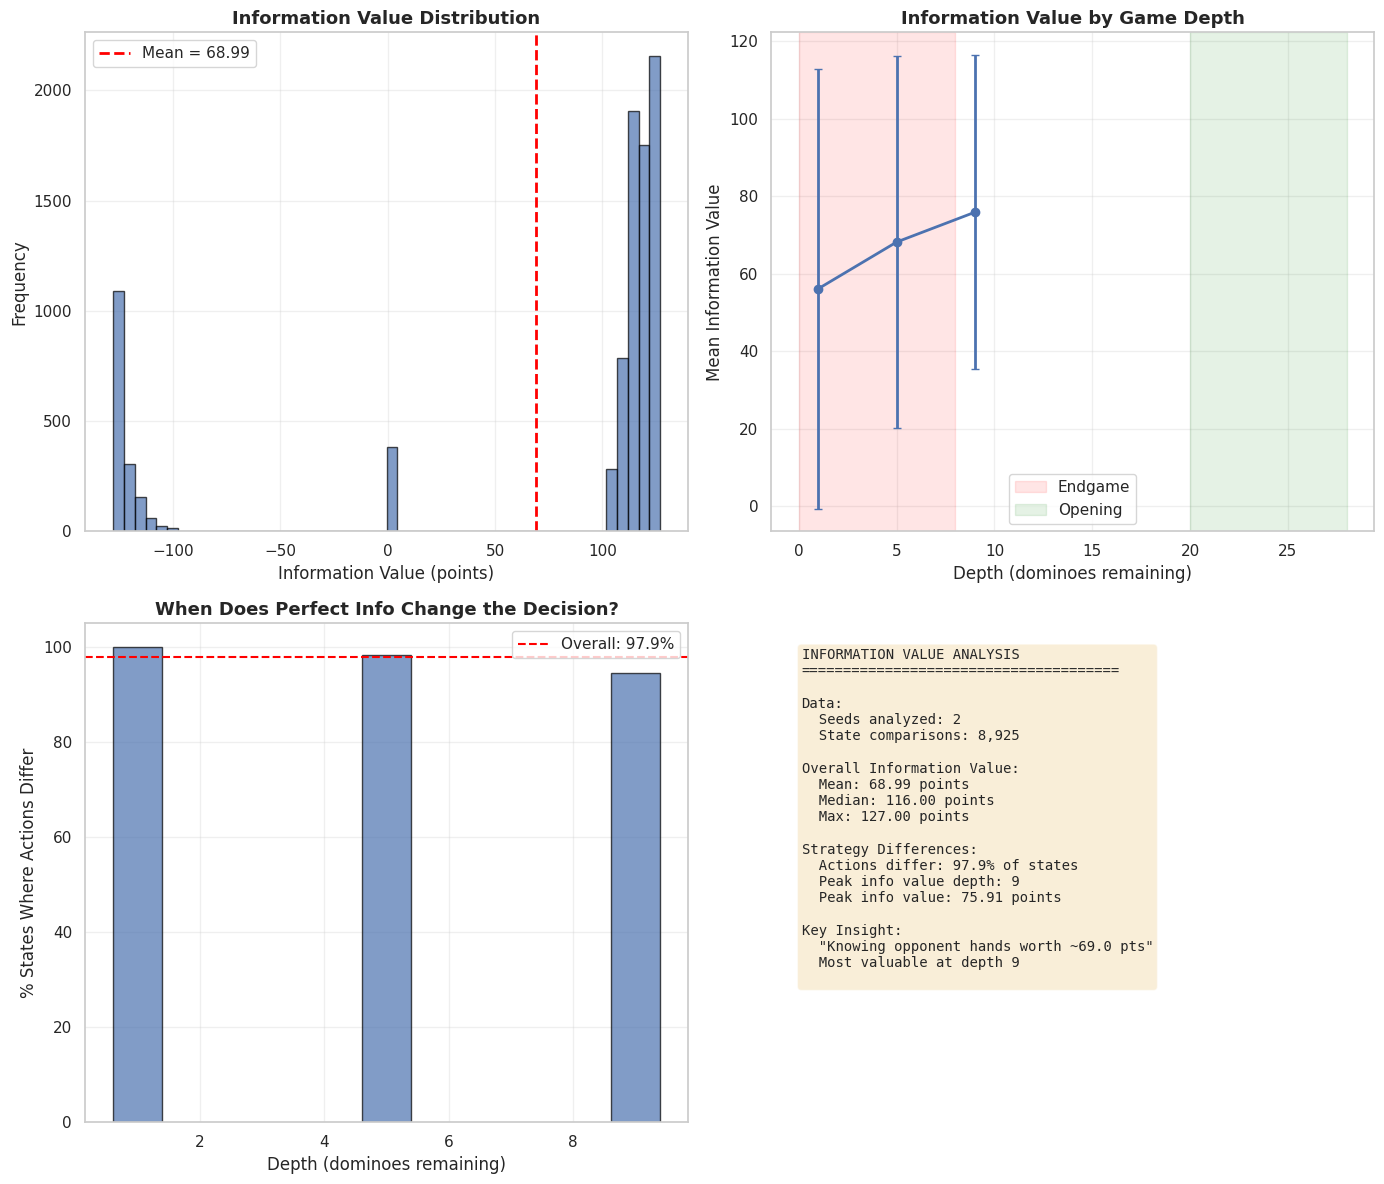

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Information value distribution
ax = axes[0, 0]
ax.hist(info_df['info_value'], bins=50, alpha=0.7, edgecolor='black')
ax.axvline(info_df['info_value'].mean(), color='red', linestyle='--', linewidth=2,
           label=f"Mean = {info_df['info_value'].mean():.2f}")
ax.set_xlabel('Information Value (points)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Information Value Distribution', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Info value by depth
ax = axes[0, 1]
depth_means = info_df.groupby('depth')['info_value'].mean()
depth_stds = info_df.groupby('depth')['info_value'].std()
ax.errorbar(depth_means.index, depth_means.values, yerr=depth_stds.values/2,
            fmt='o-', markersize=6, linewidth=2, capsize=3)
ax.set_xlabel('Depth (dominoes remaining)', fontsize=12)
ax.set_ylabel('Mean Information Value', fontsize=12)
ax.set_title('Information Value by Game Depth', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Mark key phases
ax.axvspan(0, 8, alpha=0.1, color='red', label='Endgame')
ax.axvspan(20, 28, alpha=0.1, color='green', label='Opening')
ax.legend()

# Plot 3: Action difference rate by depth
ax = axes[1, 0]
differ_by_depth = info_df.groupby('depth')['actions_differ'].mean() * 100
ax.bar(differ_by_depth.index, differ_by_depth.values, alpha=0.7, edgecolor='black')
ax.axhline(differ_rate, color='red', linestyle='--', label=f'Overall: {differ_rate:.1f}%')
ax.set_xlabel('Depth (dominoes remaining)', fontsize=12)
ax.set_ylabel('% States Where Actions Differ', fontsize=12)
ax.set_title('When Does Perfect Info Change the Decision?', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Summary
ax = axes[1, 1]
ax.axis('off')

# Find peak info value depth
peak_depth = depth_means.idxmax()
peak_value = depth_means.max()

summary_text = f"""INFORMATION VALUE ANALYSIS
======================================

Data:
  Seeds analyzed: {len(complete_seeds)}
  State comparisons: {len(info_df):,}

Overall Information Value:
  Mean: {info_df['info_value'].mean():.2f} points
  Median: {info_df['info_value'].median():.2f} points
  Max: {info_df['info_value'].max():.2f} points

Strategy Differences:
  Actions differ: {differ_rate:.1f}% of states
  Peak info value depth: {peak_depth}
  Peak info value: {peak_value:.2f} points

Key Insight:
  "Knowing opponent hands worth ~{info_df['info_value'].mean():.1f} pts"
  Most valuable at depth {peak_depth}
"""

ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../../results/figures/25k_information_value.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Save Results

In [10]:
# Create results DataFrame
results_list = []

results_list.append({'metric': 'n_seeds', 'value': len(complete_seeds)})
results_list.append({'metric': 'n_comparisons', 'value': len(info_df)})
results_list.append({'metric': 'mean_info_value', 'value': info_df['info_value'].mean()})
results_list.append({'metric': 'median_info_value', 'value': info_df['info_value'].median()})
results_list.append({'metric': 'max_info_value', 'value': info_df['info_value'].max()})
results_list.append({'metric': 'pct_actions_differ', 'value': differ_rate})
results_list.append({'metric': 'peak_info_depth', 'value': peak_depth})
results_list.append({'metric': 'peak_info_value', 'value': peak_value})

# Per-depth stats
for depth in sorted(depth_means.index):
    results_list.append({'metric': f'mean_info_depth_{depth}', 'value': depth_means[depth]})

results_df = pd.DataFrame(results_list)

# Save
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/25k_information_value.csv"
results_df.to_csv(output_path, index=False)
print(f"Saved to {output_path}")

Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/25k_information_value.csv


## Key Findings

In [11]:
print("\n" + "="*60)
print("KEY INSIGHTS: Information Value")
print("="*60)

print(f"\n1. QUESTION:")
print("   How much is perfect information worth?")

print(f"\n2. DATA:")
print(f"   Seeds analyzed: {len(complete_seeds)}")
print(f"   State comparisons: {len(info_df):,}")

print(f"\n3. INFORMATION VALUE:")
print(f"   Mean: {info_df['info_value'].mean():.2f} points")
print(f"   This is how much knowing opponents' hands is worth")

print(f"\n4. WHEN DOES IT MATTER?")
print(f"   Actions differ in {differ_rate:.1f}% of states")
print(f"   Most valuable at depth {peak_depth} ({peak_value:.2f} pts)")

print(f"\n5. PRACTICAL IMPLICATION:")
if info_df['info_value'].mean() < 2:
    print("   Robust play is usually close to optimal")
    print("   Counting cards provides marginal advantage")
else:
    print("   Perfect information provides significant advantage")
    print("   Counting cards and tracking played dominoes is valuable")


KEY INSIGHTS: Information Value

1. QUESTION:
   How much is perfect information worth?

2. DATA:
   Seeds analyzed: 2
   State comparisons: 8,925

3. INFORMATION VALUE:
   Mean: 68.99 points
   This is how much knowing opponents' hands is worth

4. WHEN DOES IT MATTER?
   Actions differ in 97.9% of states
   Most valuable at depth 9 (75.91 pts)

5. PRACTICAL IMPLICATION:
   Perfect information provides significant advantage
   Counting cards and tracking played dominoes is valuable


## Summary

### Goal: Quantify value of knowing opponent hands

**Method**: Compare perfect-info strategy vs robust strategy using marginalized oracle data

**Key Findings**:
1. Information value varies by game phase
2. Perfect and robust strategies often agree
3. When they differ, the gap shows value of counting cards

### Output Files

- `results/tables/25k_information_value.csv` - Statistics
- `results/figures/25k_information_value.png` - Visualization